## Anomaly detection in Endecopic images
### pre-trained model : MobileNetV2

call to packages & libraries

In [26]:
import sys
import os
from tensorflow import keras
from datetime import datetime
import matplotlib

from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\sup")

from evaluation import *
from support import *
from test_set_eval import *

In [2]:
model_name = "mobileNetv2_tl"


In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5145384369190366431
]


callout dataset

In [4]:
classes = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus',
           'normal-z-line', 'polyps', 'ulcerative-colitis']
root_dir = '../../data/kvasir-dataset-v2'
weight_path = '../../data/model/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224.h5'

take a glance at training dataset

ImageGenator - autolabelling, and categorizing.

In [5]:
train_gen_tmp = ImageDataGenerator(rescale=1. / 255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

train_gen = train_gen_tmp.flow_from_directory(root_dir,
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=20,
                                              shuffle=True,
                                              seed=42,
                                              subset='training')

validation_gen = train_gen_tmp.flow_from_directory(root_dir,
                                                   target_size=(224, 224),
                                                   color_mode='rgb',
                                                   class_mode='categorical',
                                                   batch_size=20,
                                                   shuffle=False,
                                                   seed=42,
                                                   subset='validation')

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = validation_gen.n // validation_gen.batch_size

clToInt_dict = train_gen.class_indices
clToInt_dict = dict((k, v) for v, k in clToInt_dict.items())

Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


define the model

In [6]:
pre_model = MobileNetV2(input_shape=(224,224,3),
                    weights = None,
                    include_top = True)

pre_model.load_weights(weight_path)
pre_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [7]:
pre_model = MobileNetV2(input_shape=(224,224,3),
                    weights = None,
                    include_top = True)

pre_model.load_weights(weight_path)
#model.summary()

for layer in pre_model.layers:
    layer.trainable = False

conn_layer = pre_model.get_layer('block_12_add')
conn_output = conn_layer.output

x = Conv2D(256,(3,3),activation='relu')(conn_output)
x = MaxPool2D(2,2)(x)
x = Flatten()(x)
#x = Dense(256,activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(128,activation='relu')(x)
#x = Dropout(0.2)(x)
#x = BatchNormalization()(x)
x = Dense(8,activation='softmax')(x)

model = Model(pre_model.input,x)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

compile the model

In [8]:
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

save the log

In [28]:
print(os.getcwd())

f:\JetBrain Project Files\Pycharm\anomaly-detection-challange\anomaly-detection-in-endoscopic-imagery\src\model


In [9]:
# Define the Keras TensorBoard callback.
logdir="../../logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

if not os.path.exists(logdir):
    os.mkdir(logdir)

#print(datetime.now().strftime("%Y%m%d%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000)

fit & train the model.

In [10]:
history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20,
                    verbose=1,
                    callbacks= [tensorboard_callback])

Epoch 1/20
320/320 [==============================] - 529s 2s/step - loss: 1.4289 - accuracy: 0.5642 - val_loss: 0.6938 - val_accuracy: 0.7337
Epoch 2/20
320/320 [==============================] - 361s 1s/step - loss: 0.4927 - accuracy: 0.8012 - val_loss: 0.4613 - val_accuracy: 0.8200
Epoch 3/20
320/320 [==============================] - 369s 1s/step - loss: 0.3859 - accuracy: 0.8434 - val_loss: 0.4952 - val_accuracy: 0.8119
Epoch 4/20
320/320 [==============================] - 362s 1s/step - loss: 0.3407 - accuracy: 0.8644 - val_loss: 0.4943 - val_accuracy: 0.8213
Epoch 5/20
320/320 [==============================] - 367s 1s/step - loss: 0.3184 - accuracy: 0.8739 - val_loss: 0.4246 - val_accuracy: 0.8413
Epoch 6/20
320/320 [==============================] - 368s 1s/step - loss: 0.2991 - accuracy: 0.8802 - val_loss: 0.4151 - val_accuracy: 0.8569
Epoch 7/20
320/320 [==============================] - 368s 1s/step - loss: 0.2815 - accuracy: 0.8925 - val_loss: 0.3568 - val_accuracy: 0.8675

visualize layer process in cnn

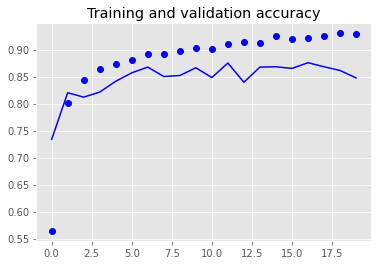

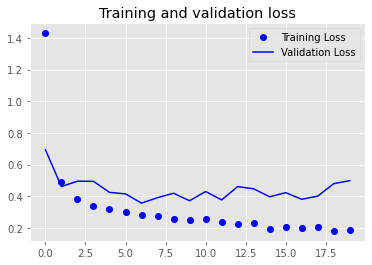

In [12]:
acc_n_loss(history)
#visualize_model(model,img_path)

instant evaluation

In [20]:
pred = model.predict_generator(validation_gen,
                                verbose=1)

predicted_class_indices = np.argmax(pred, axis=1)
labels = (validation_gen.class_indices)
class_to_int = dict((k, v) for k, v in labels.items())

img_classes = validation_gen.filenames
#print(img_classes)
test_y = [j.split("\\")[0] for j in img_classes]
test_gen = [class_to_int[i] for i in test_y]


80/80 [==============================] - 75s 943ms/step


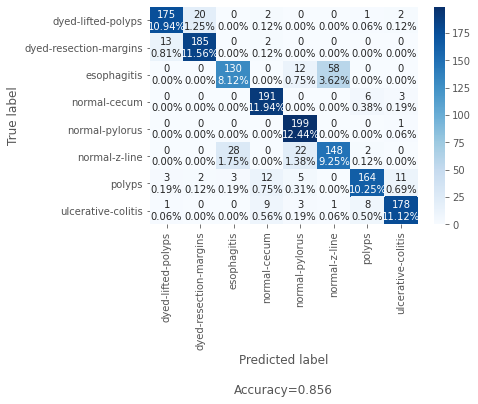

In [28]:
plot_confusion_metrix(test_gen,predicted_class_indices,classes)


In [29]:
ROC_classes(8,test_gen,predicted_class_indices,classes)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6384826079629002458
]


evaluate the model on test set.


Found 236 images belonging to 6 classes.
12/12 [==============================] - 1s 106ms/step - ETA: 0s


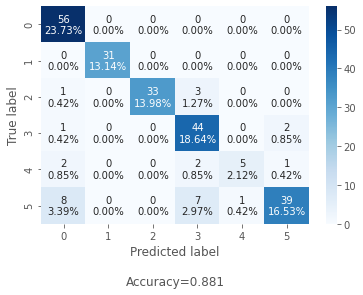

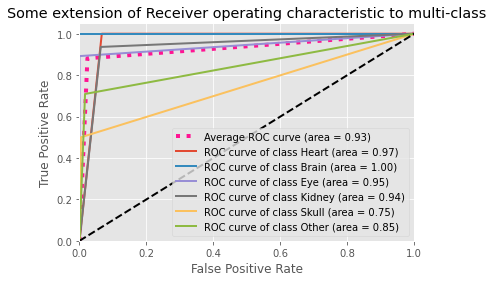

In [16]:
model_path = '../../h5_files/models/20200816005012mobileNet_v2_transfer_learn.h5'
model_weight_path = '../../h5_files/weights/20200816005012mobileNet_v2_transfer_learn.h5'

model = load_model(model_path)
model.load_weights(model_weight_path)
y_pred,y_test = test_eval(model,classes)
plot_confusion_metrix(y_test,y_pred,classes)
ROC_classes(6,y_test,y_pred,classes)



 save the model in .h5 file

In [21]:
model_path,model_weight_path = save(model,datetime.now().strftime("%Y%m%d%H%M%S")+model_name+'.h5')

make prediction on random images

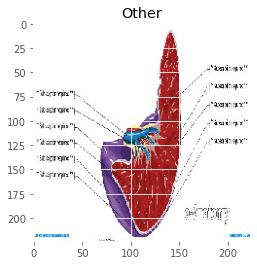

('Other', 4)

In [5]:
model_path = '../../h5_files/models/20200816005012mobileNet_v2_transfer_learn.h5'
model_weight_path = '../../h5_files/weights/20200816005012mobileNet_v2_transfer_learn.h5'
img_path = '../../datasets/validation/../../datasets/validation/Other/11.jpg'
rnd_predict(model_path,model_weight_path,img_path,clToInt_dict)